In [4]:
import numpy as np
import pandas as pd
from urllib2 import Request, urlopen
import json
import sys
from pandas.io.json import json_normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import LogisticRegressionCV as LogRegCV
from sklearn import svm
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
%matplotlib inline

/Users/JSoyinka/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [5]:
# Import Dataset
data = pd.read_csv("Reviews.csv", index_col=0)

no_dupes = data.drop(data[data.duplicated(subset=['Time', 'Summary', 'Text', 'UserId'])].index)
print data.shape[0] - no_dupes.shape[0], "Duplicate Observations Dropped"

no_dupes.to_csv("cleaned_data.csv")

173323 Duplicate Observations Dropped


In [6]:
cleaned_data = pd.read_csv("cleaned_data.csv")
cleaned_data.head(n=3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


Sort to reviews where the denominator is over 15.

In [9]:
rand_1400 = cleaned_data[cleaned_data["HelpfulnessDenominator"] > 15]
rand_1400.shape

(7786, 10)

In [10]:
'The original set has {0} entries, while our testing set only has {1}.'.format(cleaned_data.shape[0], rand_1400.shape[0])

'The original set has 395131 entries, while our testing set only has 7786.'

Range of Review Lengths: 6 words - 2233 words
Mean of Review Lengths: 158.85550989


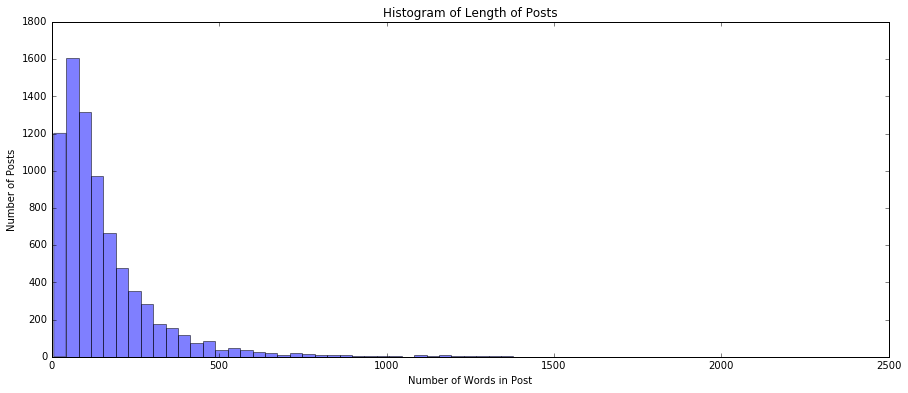

In [11]:
# Splits each review by spaces.
lengths = rand_1400['Text'].apply(lambda x: len(x.split(' ')))

print 'Range of Review Lengths: {0} words - {1} words'.format(np.min(lengths), np.max(lengths))
print 'Mean of Review Lengths: {}'.format(np.mean(lengths))

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# Histogram of the word counts in each post
ax.hist(lengths, color='blue', bins=60, alpha=0.5)

ax.set_xlabel('Number of Words in Post')
ax.set_ylabel('Number of Posts')
ax.set_title('Histogram of Length of Posts')

plt.show()

Create a vectorizer. Get the names of all the words. Get the frequency of the words. Zip that shit together and return the top 20 words, using the frequency part of the tuple.

In [12]:
# Create a text vectorizer (turns text into array of numbers)
vectorizer = CountVectorizer(stop_words='english', min_df=1, binary=True)

# Get all the text from data
corpus = rand_1400['Text'].values

# Turn each text into an array of word counts
x = vectorizer.fit_transform(corpus)
x = x.toarray()

# Get the names of all the words we're counting
feature_names = vectorizer.get_feature_names()

#Number of top words
n = 20

#Count the number of time each word occurs in the entire dataset
word_freq = x.sum(axis=0)

#Sort the words by their total frequency in the dataset
words = zip(word_freq, feature_names)
top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

Plot the top 20 words.

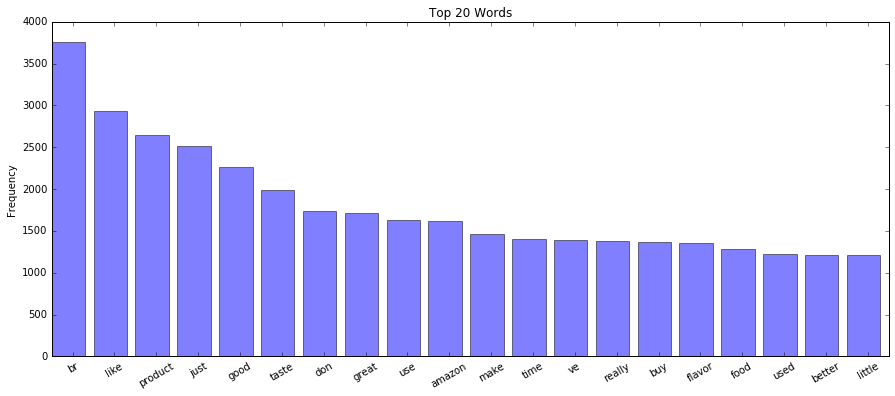

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# Number of bars to use
indices = np.arange(n)
# Where to put the label under each bar
width = 0.5
# Bar plot of the frequencies of the top words
ax.bar(indices, [word[0] for word in top_words], color='blue', alpha=0.5)

ax.set_ylabel('Frequency')
ax.set_title('Top ' + str(n) + ' Words')

# Label the bars with the top words
ax.set_xticks(indices + width)
ax.set_xticklabels([word[1] for word in top_words])

# Turn the labels sideways so they don't overlap
labels = ax.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)

plt.show()

Create a y np.array using the helpfulness numerator over the denominator.

In [19]:
# Encode the class labels, things sometimes get funky if you don't do this.
y_numerator = rand_1400['HelpfulnessNumerator'].values
y_denominator = (rand_1400['HelpfulnessDenominator'].values).astype(float)
y = y_numerator / y_denominator

print "Numerator values:", y_numerator[20:25]
print "Denominator values:", y_denominator[20:25]
print "Resulting quotient:", y[20:25]

Numerator values: [ 5  5 14 32 24]
Denominator values: [ 16.  27.  17.  36.  27.]
Resulting quotient: [ 0.3125      0.18518519  0.82352941  0.88888889  0.88888889]


Check the number of reviews for consistency.

In [20]:
print 'Number of sub 50% reviews:', len(y[y <= 1./2])
print 'Number of sub 100% reviews:', len(y[y > 1./2])

Number of sub 50% reviews: 1402
Number of sub 100% reviews: 6384


Convert to a 1 vs 2 system, where reviews are given a 2 if over half of users found them helpful and a 1 otherwise. Check the number of reviews for consistency.

In [21]:
y[y > 1./2] = 2
y[y <= 1./2] = 1

In [22]:
print 'Number of sub 50% reviews:', len(y[y == 1])
print 'Number of sub 100% reviews:', len(y[y == 2])

Number of sub 50% reviews: 1402
Number of sub 100% reviews: 6384


Plot the top 20 words

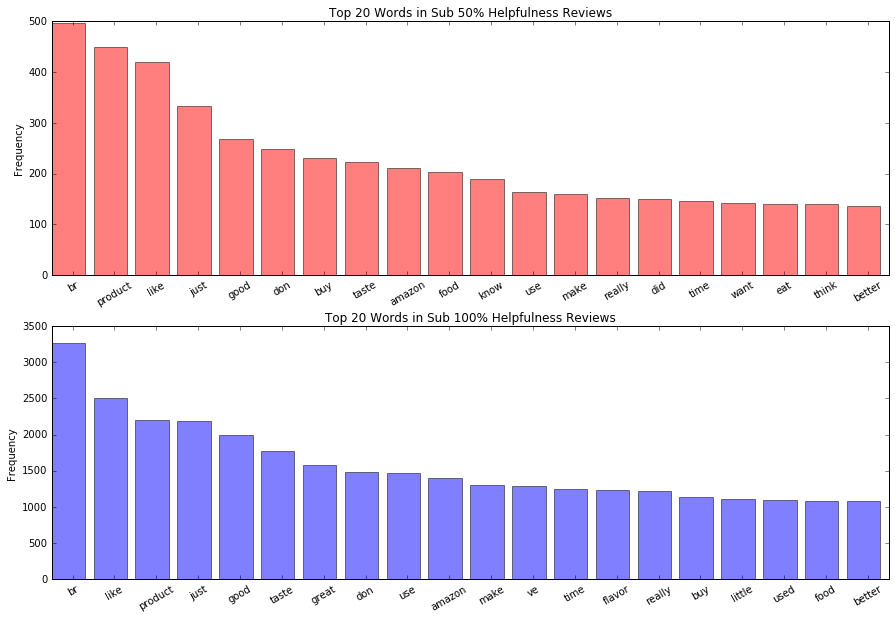

In [27]:
colors = ["red", "blue"]
percents = ["Sub 50%", "Sub 100%"]
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

for i in range(2):
    #Number of bars to use
    indices = np.arange(n)
    #Where to put the label under each bar
    width = 0.5

    #Count the number of time each word occurs
    word_freq = x[y == i+1].sum(axis=0)

    # Sort the words by their total frequency in the dataset
    words = zip(word_freq, feature_names)
    top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

    #B ar plot of the frequencies of the top words
    ax[i].bar(indices, [word[0] for word in top_words], color=colors[i], alpha=0.5)

    ax[i].set_ylabel('Frequency')
    ax[i].set_title('Top ' + str(n) + ' Words in ' + percents[i] + ' Helpfulness Reviews')

    # Label the bars with the top words
    ax[i].set_xticks(indices + width)
    ax[i].set_xticklabels([word[1] for word in top_words])

    # Turn the labels sideways so they don't overlap
    labels = ax[i].get_xticklabels()
    plt.setp(labels, rotation=30, fontsize=10)

plt.show()

Split into a testing and a training set. 2/3 vs. 1/3 respectively. Then run a logistic model on that

In [28]:
# Train/test split
n_samples = len(x)
train_indices = np.random.uniform(size=n_samples) > 1. / 3.  #Select two thirds for train

x_train = x[train_indices]
y_train = y[train_indices]
print "Reviews in Training Set: {0}".format(x_train.shape[0])
x_test = x[~train_indices]
y_test = y[~train_indices]

#Generate array of L2 regularization parameters
regularization = 10.**np.arange(-10, 5)

#Fit logistic model with cross validation to select the optimal regularization parameter
logistic = LogRegCV(cv=5, penalty='l2', Cs=regularization, solver='liblinear', n_jobs=4)
logistic.fit(x_train, y_train)

#Print results
print 'Accuracy on overall test set:', logistic.score(x_test, y_test)
print 'Accuracy on Sub 50% set:', logistic.score(x_test[y_test == 1], y_test[y_test == 1])
print 'Accuracy on Sub 100% set:', logistic.score(x_test[y_test == 2], y_test[y_test == 2])

Reviews in Training Set: 5183
Accuracy on overall test set: 0.830195927776
Accuracy on Sub 50% set: 0.197095435685
Accuracy on Sub 100% set: 0.974068835455


In [29]:
# This function computes the accuracy of logistic regression given cut-offs, min_df, max_df

In [30]:
def vectorize_classify(min_df, max_df, trials, x, y):
    #Create a text vectorizer, removing words with frequency less than min_df or
    #greater than max_df
    vectorizer = CountVectorizer(stop_words='english', min_df=min_df, max_df=max_df)
    #Transform our text into arrays of numbers
    corpus = rand_1400['Text'].values
    x = vectorizer.fit_transform(corpus)
    x = x.toarray()
    
    #Record overall accuracy rate, accuracy on class 1 and class 2
    overall_acc = []
    class_2_acc = []
    class_1_acc = []
    
    
    n_samples = len(x)
    
    #Perform logistic regression on a handful of train/test splits
    for i in range(trials):
        #Print progress
        sys.stdout.write("\r{0}% completed".format((float(i + 1)/trials)*100))
        sys.stdout.flush()
        
        # Train/test split
        train_indices = np.random.uniform(size=n_samples) > 1. / 3.  #Select two thirds for train

        x_train = x[train_indices]
        y_train = y[train_indices]

        x_test = x[~train_indices]
        y_test = y[~train_indices]

        #Generate array of L2 regularization parameters
        regularization = 10. ** np.arange(-10, 5)

        #Fit logistic model
        logistic = LogRegCV(cv=5, 
                            penalty='l2', 
                            Cs=regularization, 
                            solver='liblinear', 
                            n_jobs=4)
        logistic.fit(x_train, y_train)
        
        overall_acc.append(logistic.score(x_test, y_test))
        class_1_acc.append(logistic.score(x_test[y_test == 1], y_test[y_test == 1]))
        class_2_acc.append(logistic.score(x_test[y_test == 2], y_test[y_test == 2]))

    return (np.mean(overall_acc), 
            np.mean(class_1_acc),
            np.mean(class_2_acc))

This takes a long time to run with multiple dataframe configurations, so this is just one example, there weren't many permuations that performed well, and even those didn't meet a suffienct mark in terms of accurate predictions.

In [31]:
min_df = 1
max_df = 100
trials = 5
overall, class_1, class_2 = vectorize_classify(min_df, max_df, trials, x, y)
print '\nMin frequency, max frequency:', min_df, ',', max_df
print 'Accuracy on overall test set:', overall
print 'Accuracy on class 1 in test set:', class_1
print 'Accuracy on class 2 in test set:', class_2

100.0% completed
Min frequency, max frequency: 1 , 100
Accuracy on overall test set: 0.821034475193
Accuracy on class 1 in test set: 0.0108991128298
Accuracy on class 2 in test set: 0.998417565736


Quick test of c parameters to improve our logistic regression.

C= 0.0001 : 0.822496684824
C= 0.001 : 0.822496684824
C= 0.01 : 0.822496684824
C= 0.1 : 0.819601937635
C= 1 : 0.806482754831
C= 10 : 0.789504988848
C= 100 : 0.784101632032


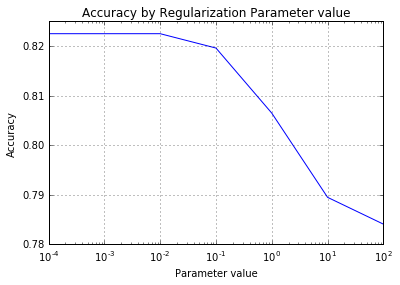

In [34]:
cvals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
scores = []
for c in cvals: #try cross validating the data with different regularization parameters
    log_model = LogReg(C=c, penalty='l2') #initiate unregularized logistic regression model
    score = cross_val_score(log_model, x_train, y_train, n_jobs=-1).mean() #cross validate
    scores.append(score)
    print "C=",c ,":", score
    
plt.plot(cvals, scores)
plt.xscale('log')
plt.title("Accuracy by Regularization Parameter value")
plt.xlabel("Parameter value")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

As one would expect the C value with the highest value overfit, giving us a 19% vs 97% accuracy with Class 1 vs. Class 2, but C = 10 was more balacnced at 43% vs. 89%.

In [44]:
log_model = LogReg(C=10, penalty='l2')
log_model.fit(x_train, y_train)
y_predict = log_model.predict(x_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel() #from sklearn docs
print y_predict.shape
print y_test.shape
print "\n\nWITH CLASS BALANCE CORRECTION"
print confusion_matrix(y_test, y_predict)
print
print "False Positive Rate:", fp/float(fp+tn)
print "False Negative Rate:", fn/float(fn+tp)
print "True Positive Rate:", tp/float(tp+fp)
print "True Negative Rate:", tn/float(tn+fn)
print
print "Accuracy on 2 Class Helpfulness:", np.mean(y_predict[y_test == 2] == y_test[y_test == 2])
print "Accuracy on 1 Class Helpfulness:", np.mean(y_predict[y_test == 1] == y_test[y_test == 1])

(2603,)
(2603,)


WITH CLASS BALANCE CORRECTION
[[ 210  272]
 [ 217 1904]]

False Positive Rate: 0.564315352697
False Negative Rate: 0.102310231023
True Positive Rate: 0.875
True Negative Rate: 0.491803278689

Accuracy on 2 Class Helpfulness: 0.897689768977
Accuracy on 1 Class Helpfulness: 0.435684647303


C= 0.0001 : 0.795097560888
C= 0.001 : 0.713289565864
C= 0.01 : 0.749176679213
C= 0.1 : 0.773102910742
C= 1 : 0.769437340496
C= 10 : 0.765964001301
C= 100 : 0.765771100066


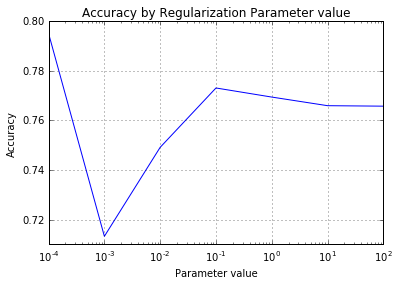

In [50]:
cvals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
scores = []
for c in cvals: #try cross validating the data with different regularization parameters
    svc = svm.LinearSVC(C=c, penalty='l2', class_weight='balanced') #initialize svc
    score = cross_val_score(svc, x_train, y_train, n_jobs=-1).mean() #cross validate
    scores.append(score)
    print "C=",c ,":", score
    
plt.plot(cvals, scores)
plt.xscale('log')
plt.title("Accuracy by Regularization Parameter value")
plt.xlabel("Parameter value")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [70]:
svc = svm.LinearSVC(C=.006, penalty='l2', class_weight='balanced') #initialize logistic regression model
svc.fit(x_train, list(y_train))
y_pred_svc = svc.predict(x_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_svc).ravel() #from sklearn docs
print y_pred_svc.shape
print y_test.shape
print "\n\nWITH CLASS BALANCE CORRECTION"
print confusion_matrix(y_test, y_pred_svc)
print
print "False Positive Rate:", fp/float(fp+tn)
print "False Negative Rate:", fn/float(fn+tp)
print "True Positive Rate:", tp/float(tp+fp)
print "True Negative Rate:", tn/float(tn+fn)
print
print "Accuracy on 2 Class Helpfulness:", np.mean(y_pred_svc[y_test == 2] == y_test[y_test == 2])
print "Accuracy on 1 Class Helpfulness:", np.mean(y_pred_svc[y_test == 1] == y_test[y_test == 1])

(2603,)
(2603,)


WITH CLASS BALANCE CORRECTION
[[ 363  119]
 [ 539 1582]]

False Positive Rate: 0.246887966805
False Negative Rate: 0.254125412541
True Positive Rate: 0.930041152263
True Negative Rate: 0.40243902439

Accuracy on 2 Class Helpfulness: 0.745874587459
Accuracy on 1 Class Helpfulness: 0.753112033195


Small Sampling of Random Forests Tests

In [80]:
# Parameters for tuning
n_trees = np.arange(10, 50, 20)  # Trees and depth are explored on an exponentially growing space,
depths = np.arange(2, 5)   # since it is assumed that trees and depth will add accuracy in a decaying fashion.

# To keep track of the best model
best_score = 0

# Run grid search for model with 5-fold cross validation
print '5-fold cross validation:'

for trees in n_trees:
    for depth in depths:
        
        # Cross validation for every experiment
        k_folds = KFold(x_train.shape[0], n_folds=5, shuffle=True)
        scores = []
        for train_indices, validation_indices in k_folds:
            # Generate training data
            x_train_cv = x_train[train_indices]
            y_train_cv = y_train[train_indices]
            # Generate validation data
            x_validate = x_train[validation_indices]
            y_validate = y_train[validation_indices]      
            
            # Fit random forest on training data
            model = RandomForestClassifier(n_estimators=trees, max_depth=depth)
            model.fit(x_train_cv, y_train_cv)
            # Score on validation data
            scores += [model.score(x_validate, y_validate)]
        
        # Record and report accuracy
        average_score = np.mean(scores)
        print "Trees:", trees, "Depth:", depth, "Score:", average_score
        
        # Update our record of the best parameters see so far
        if average_score > best_score:
            best_score = average_score
            best_trees = trees
            best_depth = depth

# Fit model on entire train set using chosen number of trees and depth
model = RandomForestClassifier(n_estimators=best_trees, max_depth=best_depth)
model.fit(x_train, y_train)
y_pred_rfc = model.predict(x_test)

print 'Chosen number of trees, depth:', best_trees, ',', best_depth
print "Accuracy on 2 Class Helpfulness:", np.mean(y_pred_rfc[y_test == 2] == y_test[y_test == 2])
print "Accuracy on 1 Class Helpfulness:", np.mean(y_pred_rfc[y_test == 1] == y_test[y_test == 1])

5-fold cross validation:
Trees: 10 Depth: 2 Score: 0.822495466951
Trees: 10 Depth: 3 Score: 0.822502541114
Trees: 10 Depth: 4 Score: 0.822497328573
Trees: 30 Depth: 2 Score: 0.822493046842
Trees: 30 Depth: 3 Score: 0.822496770086
Trees: 30 Depth: 4 Score: 0.822501796465
Chosen number of trees, depth: 10 , 3
Accuracy on 2 Class Helpfulness: 1.0
Accuracy on 1 Class Helpfulness: 0.0


In [89]:
model = RandomForestClassifier(n_estimators=300, criterion='gini', 
                              max_features= 15, max_depth=5, class_weight='balanced')
model.fit(x_train, y_train)
y_pred_rfc = model.predict(x_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rfc).ravel() #from sklearn docs
print y_pred_rfc.shape
print y_test.shape
print "\n\nWITH CLASS BALANCE CORRECTION"
print confusion_matrix(y_test, y_pred_rfc)
print
print "False Positive Rate:", fp/float(fp+tn)
print "False Negative Rate:", fn/float(fn+tp)
print "True Positive Rate:", tp/float(tp+fp)
print "True Negative Rate:", tn/float(tn+fn)
print
print "Accuracy on 2 Class Helpfulness:", np.mean(y_pred_rfc[y_test == 2] == y_test[y_test == 2])
print "Accuracy on 1 Class Helpfulness:", np.mean(y_pred_rfc[y_test == 1] == y_test[y_test == 1])

(2603,)
(2603,)


WITH CLASS BALANCE CORRECTION
[[ 359  123]
 [ 779 1342]]

False Positive Rate: 0.255186721992
False Negative Rate: 0.367279585101
True Positive Rate: 0.916040955631
True Negative Rate: 0.31546572935

Accuracy on 2 Class Helpfulness: 0.632720414899
Accuracy on 1 Class Helpfulness: 0.744813278008


In [108]:
new_trainer = rand_1400.sample(frac=.5)
new_tester = rand_1400.drop(new_trainer.index.tolist())

tr_numerator = new_trainer['HelpfulnessNumerator'].values
tr_denominator = (new_trainer['HelpfulnessDenominator'].values).astype(float)
tr_y = tr_numerator / tr_denominator

tr_y[tr_y > 1./2] = 2
tr_y[tr_y <= 1./2] = 1
te_numerator = new_tester['HelpfulnessNumerator'].values
te_denominator = (new_tester['HelpfulnessDenominator'].values).astype(float)
te_y = te_numerator / te_denominator
te_y = np.nan_to_num(te_y)
te_y[te_y > 1./2] = 2
te_y[te_y <= 1./2] = 1


[71 24 21 ..., 36 17 15]
[ 75.  31.  23. ...,  46.  24.  32.]
[ 2.  2.  2. ...,  2.  2.  1.]
707
3186


In [103]:
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english', min_df=1, binary=True)), ('tfidf', TfidfTransformer()), 
                     ('clf', MultinomialNB(alpha=0.01)),])
text_clf = text_clf.fit(new_trainer['Text'].values, tr_y)
predicted = text_clf.predict(new_tester['Text'].values)
print np.mean(predicted==te_y)

0.823272540457


In [100]:
tn, fp, fn, tp = confusion_matrix(te_y, predicted).ravel() #from sklearn docs
print predicted.shape
print te_y.shape
print "\n\nWITH CLASS BALANCE CORRECTION"
print confusion_matrix(te_y, predicted)
print
print "False Positive Rate:", fp/float(fp+tn)
print "False Negative Rate:", fn/float(fn+tp)
print "True Positive Rate:", tp/float(tp+fp)
print "True Negative Rate:", tn/float(tn+fn)
print
print "Accuracy on 2 Class Helpfulness:", np.mean(predicted[te_y == 2] == te_y[te_y == 2])
print "Accuracy on 1 Class Helpfulness:", np.mean(predicted[te_y == 1] == te_y[te_y == 1])

(3893,)
(3893,)


WITH CLASS BALANCE CORRECTION
[[  36  685]
 [  35 3137]]

False Positive Rate: 0.950069348128
False Negative Rate: 0.0110340479193
True Positive Rate: 0.820774463632
True Negative Rate: 0.507042253521

Accuracy on 2 Class Helpfulness: 0.988965952081
Accuracy on 1 Class Helpfulness: 0.0499306518724
